# Intermediate Bioinformatics for Parkinson’s Disease Genetics

* __Module I:__ Post Genome Wide Association Studies on Parkinson's disease. Part 1 - Locus zoom, FUMA, COJO, Fine-mapping and Coloc.

* __Authors:__ Benjamin Jacobs on behalf of the Global Parkinson's Genetics Program (GP2) from Aligning Science Across Parkinson's (ASAP)

* __Estimated Computation and Runtime:__
    * Estimated Specifications: 4 CPUs, 26 GB memory, 50 GB Persistent Disk
    * Estimated Runtime: 2 h total 

* __Date last updated:__ 25-JUL-2022

## Quick Description:

This notebook will walk you through post-GWAS analysis. 

## Background/Motivation:

Genome-wide association studies (GWAS) provide a list of genomic variants which are associated with your disease/trait of interest. But on its own this information is not very useful. We are interested in understand how and why variation at specific sites in our DNA can influence the risk of disease. There are several bioinformatic tools that you can use to help interpret your GWAS results. Here, we cover some of the most important tools. 

## Workflow Summary:

0. Getting started
1. Generate a locus zoom plot
2. Conduct Functional Mapping and Annotation of Genome-Wide Association Studies (FUMA)
3. Perform Conditional and joint multiple-SNP analysis of GWAS summary statistics
4. Fine-mapping and colocalization

## Workflow:

### [0. Getting Started](#0)

This section goes through:
* Setting up Python libraries, data path variables, and functions
* Installing plink and gcta
* Copying data to workspace
* Look at format of summary statistics

### [1. Generate a locus zoom plot](#1)

This section goes through:
* Extracting the SNCA region from summary statistics
* Copying the output file into your bucket
* Download the file and upload it to LocusZoom

### [2. Conduct Functional Mapping and Annotation of Genome-Wide Association Studies (FUMA)](#2)

This section goes through:
* Formatting summary statistics following FUMA requirements
* Navigate through FUMA

### [3. Perform Conditional and joint multiple-SNP analysis of GWAS summary statistics](#3)

This section goes through:
* Select multiple associated SNPs through a stepwise selection procedure
* Select a fixed number of of top associated SNPs through a stepwise selection procedure
* Estimate the joint effects of a subset of SNPs (given in the file test.snplist) without model selection
* Perform single-SNP association analyses conditional on a set of SNPs 

### [4. Fine-mapping and colocalization analyses](#4)

This section goes through:
* Format data for coloc
* Run fine-mapping analyses to find approximate bayes factors
* Plot with GWAS P values and posterior probabilities from fine mapping analyses

## 0. Getting started
<a id="0"></a>

### Set up libraries

In [3]:
# Use the os package to interact with the environment
import os

# Bring in Pandas for Dataframe functionality
import pandas as pd

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]

# Import seaborn for plots
import seaborn as sns

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

### Set up billing project and data path variables

In [2]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## AMP-PD v2.5
## Explicitly define release v2.5 path 
AMP_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
AMP_CLINICAL_RELEASE_PATH = f'{AMP_RELEASE_PATH}/clinical'

AMP_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
AMP_WGS_RELEASE_PLINK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'plink')
AMP_WGS_RELEASE_GATK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'gatk')

## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')

print('AMP-PD v2.5')
print(f'Path to AMP-PD v2.5 Clinical Data: {AMP_CLINICAL_RELEASE_PATH}')
print(f'Path to AMP-PD v2.5 WGS Data: {AMP_WGS_RELEASE_PLINK_PATH}')
print('')

## GP2 v2.0
GP2_RELEASE_PATH = 'gs://gp2tier2/release2_06052022'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v2.0')
print(f'Path to GP2 v2.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v2.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v2.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')


Billing and Workspace
Workspace Name: GP2 Bioinformatics Course 2
Billing Project: terra-9b559320
Workspace Bucket, where you can upload and download data: gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914

AMP-PD v2.5
Path to AMP-PD v2.5 Clinical Data: gs://amp-pd-data/releases/2021_v2-5release_0510/clinical
Path to AMP-PD v2.5 WGS Data: gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/plink

GP2 v2.0
Path to GP2 v2.0 Clinical Data: gs://gp2tier2/release2_06052022/clinical_data
Path to GP2 v2.0 Raw Genotype Data: gs://gp2tier2/release2_06052022/raw_genotypes
Path to GP2 v2.0 Imputed Genotype Data: gs://gp2tier2/release2_06052022/imputed_genotypes


### Set up functions

In [3]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}')
    !$command

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))
    
# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)
    
# Get the data from a query
def bq_query(query):
    """Return the contents of a query against BigQuery"""
    return pd.read_gbq(
        query,
        project_id=BILLING_PROJECT_ID,
        dialect='standard')

### Installing packages

In [4]:
%%capture
%%bash
# Install plink 1.9
cd /home/jupyter/
if test -e /home/jupyter/plink; then

echo "Plink is already installed in /home/jupyter/"
else
echo "Plink is not installed"
cd /home/jupyter

wget http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 

unzip -o plink_linux_x86_64_20190304.zip
mv plink plink1.9

fi

In [5]:
%%capture
%%bash
# Install plink 2.0
cd /home/jupyter/
if test -e /home/jupyter/plink2; then

echo "Plink2 is already installed in /home/jupyter/"
else
echo "Plink2 is not installed"
cd /home/jupyter/

wget http://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_latest.zip

unzip -o plink2_linux_x86_64_latest.zip

fi

In [6]:
%%bash
# chmod plink 2.0 to make sure you have permission to run the program
chmod u+x /home/jupyter/plink2

In [7]:
%%bash
# chmod plink 1.9 to make sure you have permission to run the program
chmod u+x /home/jupyter/plink1.9

In [8]:
%%capture
%%bash
# Download gcta64 from https://yanglab.westlake.edu.cn/software/gcta/#Download
# Upload executable into workspace (under Data)
# Copy gcta64 from workspace into working directory
gsutil cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/gcta/gcta-1.94.1 /home/jupyter/

## 1. Generate Locus Zoom plot
<a id="1"></a>

First we're going to copy the Nalls et al (2019) summary statistics to our workspace.

Now we'll read the summary statistics into R. 

In [1]:
library(tidyverse)
# Copy summary statistics from bucket to your workspace
system("gsutil cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/META5_no23_with_rsids2.txt .")

# save the bucket 
bucket = "gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914"

# read in sum stats
df = read_tsv("META5_no23_with_rsids2.txt")

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Rows: 7862086 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): MarkerName, Allele1, Allele2, Direction, ID
dbl (11): Freq1, FreqSE, MinFreq, MaxFreq, Effect, StdErr, P-value, HetISq, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


 A quick look at those sumary statistics:

In [2]:
head(df)

MarkerName,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr10:100000625,a,g,0.5707,0.0094,0.5577,0.5943,0.0181,0.0179,0.3132,++++-++---+-+,0.0,9.494,12,0.6603,rs7899632
chr10:100000645,a,c,0.7911,0.0133,0.7208,0.8111,-0.0314,0.0210,0.1355,+-------+--+-,0.0,10.337,12,0.5864,rs61875309
chr10:100001867,t,c,0.0133,0.0029,0.0044,0.0178,-0.1223,0.1184,0.3016,?--?++??+-+--,0.0,6.707,8,0.5686,rs150203744
chr10:100002464,t,c,0.9859,0.0030,0.9792,0.9912,0.0015,0.1160,0.9895,?--?++??+--++,4.9,8.410,8,0.3944,rs111551711
chr10:100003242,t,g,0.8789,0.0122,0.8582,0.8985,0.0071,0.0291,0.8077,-+++-++++-+-+,28.8,16.843,12,0.1556,rs12258651
chr10:100003304,a,g,0.9579,0.0044,0.9532,0.9774,-0.0157,0.0474,0.7403,+----++--+-++,0.0,3.754,12,0.9875,rs72828461


We'll prepare the sum stats for LocusZoom. To do this we will extract the SNPs within the SNCA locus. This gene is located at 
chr4:90,645,250-90,759,455 on hg19 (https://www.genecards.org/cgi-bin/carddisp.pl?gene=SNCA).

In [3]:
# These summary stats don't have separate columns for chromosome and BP. We'll make them.
df = df %>% 
    separate(MarkerName,sep=":",into=c("CHR","BP")) %>% 
    mutate(CHR = str_remove(CHR,pattern="chr"))

In [4]:
head(df)

CHR,BP,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,ID
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
10,100000625,a,g,0.5707,0.0094,0.5577,0.5943,0.0181,0.0179,0.3132,++++-++---+-+,0.0,9.494,12,0.6603,rs7899632
10,100000645,a,c,0.7911,0.0133,0.7208,0.8111,-0.0314,0.0210,0.1355,+-------+--+-,0.0,10.337,12,0.5864,rs61875309
10,100001867,t,c,0.0133,0.0029,0.0044,0.0178,-0.1223,0.1184,0.3016,?--?++??+-+--,0.0,6.707,8,0.5686,rs150203744
10,100002464,t,c,0.9859,0.0030,0.9792,0.9912,0.0015,0.1160,0.9895,?--?++??+--++,4.9,8.410,8,0.3944,rs111551711
10,100003242,t,g,0.8789,0.0122,0.8582,0.8985,0.0071,0.0291,0.8077,-+++-++++-+-+,28.8,16.843,12,0.1556,rs12258651
10,100003304,a,g,0.9579,0.0044,0.9532,0.9774,-0.0157,0.0474,0.7403,+----++--+-++,0.0,3.754,12,0.9875,rs72828461


In [4]:
# function for chopping sum stats
chop_sumstats_locuszoom = function(sumstats,gene_chr,gene_bp_start,gene_bp_end){
  message(paste0("Chopping sum stats into region chr ",gene_chr," from ",gene_bp_start," to ", gene_bp_end," +/- 100kb"))
  sumstats = sumstats %>% mutate(BP = as.numeric(as.character(BP)), CHR = as.numeric(as.character(CHR))) %>% arrange(CHR,BP) # sort
  sumstats = sumstats %>% filter(CHR==gene_chr & BP > gene_bp_start - 100000 & BP < gene_bp_end - 100000)
  return(sumstats)
}

snca_sumstats = chop_sumstats_locuszoom(df,gene_bp_start=90645250,gene_bp_end=90759455,gene_chr=4)

# write to file
write_tsv(snca_sumstats,"snca_sumstats.tsv.gz")

# copy to local bucket
system(paste0("gsutil cp ./snca_sumstats.tsv.gz ",bucket),intern=TRUE)


Chopping sum stats into region chr 4 from 90645250 to 90759455 +/- 100kb



ERROR: Error in UseMethod("mutate"): no applicable method for 'mutate' applied to an object of class "function"


You can now download this file and upload it straight to LocusZoom. 

In [7]:
head(snca_sumstats)

CHR,BP,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,ID
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4,90545298,c,g,0.0649,0.0096,0.0418,0.0806,0.1348,0.0376,0.0003389,-+++-+-++++++,52.0,24.978,12,0.01493,rs11723723
4,90545315,a,g,0.0649,0.0096,0.0419,0.0806,0.1348,0.0376,0.0003383,-+++-+-++++++,52.0,24.979,12,0.01492,rs11723725
4,90545360,a,g,0.0377,0.0036,0.0282,0.0445,-0.1356,0.0477,0.0044480,---++-++-++--,6.5,12.834,12,0.38120,rs6852822
4,90545492,a,t,0.0641,0.0094,0.0416,0.0795,0.1283,0.0379,0.0007235,-+++-+-++++++,51.0,24.497,12,0.01740,rs75754323
4,90545495,t,c,0.0641,0.0094,0.0415,0.0795,0.1279,0.0379,0.0007489,-+++-+-++++++,51.0,24.470,12,0.01754,rs79208813
4,90545660,t,g,0.0321,0.0038,0.0261,0.0435,-0.1475,0.0522,0.0046730,---+---+-++--,0.7,12.084,12,0.43900,rs28593152


[1] "gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914"

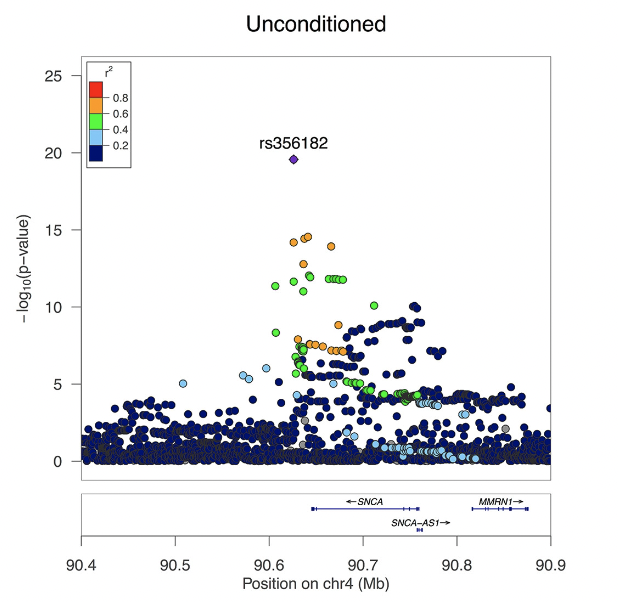


## 2. Conduct Functional Mapping and Annotation of GWAS
<a id="2"></a>

We'll prepare the sum stats for FUMA. FUMA is very flexible with the format, so all we need to do is save the sum stats and download them

In [80]:
# write to file
write_tsv(df,"full_sumstats.tsv.gz")

# copy to local bucket
system(paste0("gsutil cp ./full_sumstats.tsv.gz ",bucket),intern=TRUE)

character(0)

In [10]:
head(df)

CHR,BP,Allele1,Allele2,Freq1,FreqSE,MinFreq,MaxFreq,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,ID
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
10,100000625,a,g,0.5707,0.0094,0.5577,0.5943,0.0181,0.0179,0.3132,++++-++---+-+,0.0,9.494,12,0.6603,rs7899632
10,100000645,a,c,0.7911,0.0133,0.7208,0.8111,-0.0314,0.0210,0.1355,+-------+--+-,0.0,10.337,12,0.5864,rs61875309
10,100001867,t,c,0.0133,0.0029,0.0044,0.0178,-0.1223,0.1184,0.3016,?--?++??+-+--,0.0,6.707,8,0.5686,rs150203744
10,100002464,t,c,0.9859,0.0030,0.9792,0.9912,0.0015,0.1160,0.9895,?--?++??+--++,4.9,8.410,8,0.3944,rs111551711
10,100003242,t,g,0.8789,0.0122,0.8582,0.8985,0.0071,0.0291,0.8077,-+++-++++-+-+,28.8,16.843,12,0.1556,rs12258651
10,100003304,a,g,0.9579,0.0044,0.9532,0.9774,-0.0157,0.0474,0.7403,+----++--+-++,0.0,3.754,12,0.9875,rs72828461


## 3. Perform Conditional and joint multiple-SNP analysis of GWAS summary statistics
<a id="3"></a>

We'll move on to Conditional and Joint analysis (COJO). More information can be found here: https://yanglab.westlake.edu.cn/software/gcta/#COJO

In [7]:
# read in snca stats 
snca_sumstats = read_tsv("snca_sumstats.tsv.gz")

df_cojo = snca_sumstats %>%
    select(ID,Allele1,Allele2,Freq1,Effect,StdErr,`P-value`) %>%
    mutate(N = 50000) %>%
    rename("SNP" = ID,"A1"=Allele1,"A2"=Allele2,"freq"=Freq1,"b"=Effect,"se"=StdErr,"p"=`P-value`)

head(df_cojo)

Rows: 448 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): Allele1, Allele2, Direction, ID
dbl (13): CHR, BP, Freq1, FreqSE, MinFreq, MaxFreq, Effect, StdErr, P-value,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


SNP,A1,A2,freq,b,se,p,N
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs11723723,c,g,0.0649,0.1348,0.0376,0.0003389,50000
rs11723725,a,g,0.0649,0.1348,0.0376,0.0003383,50000
rs6852822,a,g,0.0377,-0.1356,0.0477,0.0044480,50000
rs75754323,a,t,0.0641,0.1283,0.0379,0.0007235,50000
rs79208813,t,c,0.0641,0.1279,0.0379,0.0007489,50000
rs28593152,t,g,0.0321,-0.1475,0.0522,0.0046730,50000


In [8]:
write_tsv(df_cojo,"sumstats.ma")

In [1]:
%%bash

# copy the 1kg reference files
gsutil cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/filtered_chr4.bed .
gsutil cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/filtered_chr4.bim .
gsutil cp gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/filtered_chr4.fam .

filtered_chr4.bed
filtered_chr4.bim
filtered_chr4.fam
META5_no23_with_rsids2.txt
Module_1_Intro.ipynb
Module1_part1_progressionGWAS_mixedmodels.ipynb
Module1_part2_progressionGWAS_coxmodels.ipynb
Module_2_Data_Intro_Cost_Management.ipynb
Module2_Haplotypes_RareVariants.ipynb
Module_3_Upload_Copy_Access.ipynb
Module_4_ClinicalData.ipynb
Module5_PostGWAS_analyses_Heritability_Cross_Genetic_Correlations_Mendelian_Randomization.ipynb
Module_5_PRS_and_Visualization.ipynb
Module_6_Gene_Extraction_Annotation_Burdens.ipynb
Module_7_WDL_Intro.ipynb
Module_IV_PostGWAS_analyses_LocusZoom_FUMA_COJO_Fine-mapping.ipynb
snca_sumstats.tsv.gz
sumstats.ma


Copying gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/filtered_chr4.bed...
\
Operation completed over 1 objects/83.8 MiB.                                     
Copying gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/filtered_chr4.bim...
/ [1 files][ 19.0 MiB/ 19.0 MiB]                                                
Operation completed over 1 objects/19.0 MiB.                                     
Copying gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914/filtered_chr4.fam...
/ [1 files][ 12.3 KiB/ 12.3 KiB]                                                
Operation completed over 1 objects/12.3 KiB.                                     


In [1]:
%%bash
# ensure GCTA is executable
chmod 755 /home/jupyter/gcta-1.94.1

# run GCTA
/home/jupyter/gcta-1.94.1 \
--bfile filtered_chr4 \
--chr 4 \
--maf 0.01 \
--cojo-file sumstats.ma \
--cojo-slct \
--out test_snca

*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Aug  3 2022 04:46:31, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 09:41:59 UTC on Thu Sep 01 2022.
Hostname: 7d6ea2067560

Accepted options:
--bfile filtered_chr4
--chr 4
--maf 0.01
--cojo-file sumstats.ma
--cojo-slct
--out test_snca


Reading PLINK FAM file from [filtered_chr4.fam].
503 individuals to be included from [filtered_chr4.fam].
Reading PLINK BIM file from [filtered_chr4.bim].
697392 SNPs to be included from [filtered_chr4.bim].
697392 SNPs on chromosome 4 are included in the analysis.
Reading PLINK BED file from [filtered_chr4.bed] in SNP-major format ...
Genotype data for 503 individuals and 697392 SNPs to be included from [filtered_chr4.bed].
Calculating allele fr

In [2]:
library(tidyverse)
cojo_res = read_tsv("test_snca.cma.cojo")

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Rows: 374 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): SNP, refA
dbl (11): Chr, bp, freq, b, se, p, n, freq_geno, bC, bC_se, pC

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(cojo_res)

Chr,SNP,bp,refA,freq,b,se,p,n,freq_geno,bC,bC_se,pC
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,rs11723723,90545298,C,0.0649,0.1348,0.0376,0.000336941,49333.0,0.0497018,-0.0259395,0.0376045,0.490322
4,rs11723725,90545315,A,0.0649,0.1348,0.0376,0.000336941,49333.0,0.0497018,-0.0259395,0.0376045,0.490322
4,rs6852822,90545360,A,0.0377,-0.1356,0.0477,0.004472370,51282.8,0.0357853,-0.0610715,0.0477033,0.200462
4,rs75754323,90545492,A,0.0641,0.1283,0.0379,0.000711201,49120.4,0.0497018,-0.0337673,0.0379040,0.373003
4,rs79208813,90545495,T,0.0641,0.1279,0.0379,0.000739042,49120.4,0.0497018,-0.0341672,0.0379040,0.367369
4,rs28593152,90545660,T,0.0321,-0.1475,0.0522,0.004718180,50001.5,0.0318091,-0.0516330,0.0522036,0.322630


In [4]:
# read in significant results
cojo_res_joint = read_tsv("test_snca.jma.cojo")
snca_sumstats = read_tsv("snca_sumstats.tsv.gz")

head(cojo_res_joint)

Rows: 2 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): SNP, refA
dbl (12): Chr, bp, freq, b, se, p, n, freq_geno, bJ, bJ_se, pJ, LD_r

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 448 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): Allele1, Allele2, Direction, ID
dbl (13): CHR, BP, Freq1, FreqSE, MinFreq, MaxFreq, Effect, StdErr, P-value,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Chr,SNP,bp,refA,freq,b,se,p,n,freq_geno,bJ,bJ_se,pJ,LD_r
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,rs73831461,90635338,C,0.0766,0.3649,0.0358,2.13662e-24,46599.1,0.0626243,0.237703,0.0377324,2.98224e-10,0.346757
4,rs356220,90641340,T,0.3898,0.2366,0.0176,3.37602e-41,57282.3,0.3856860,0.200035,0.0185586,4.34688e-27,0.000000


Warning message:
“Removed 23 rows containing missing values (geom_point).”


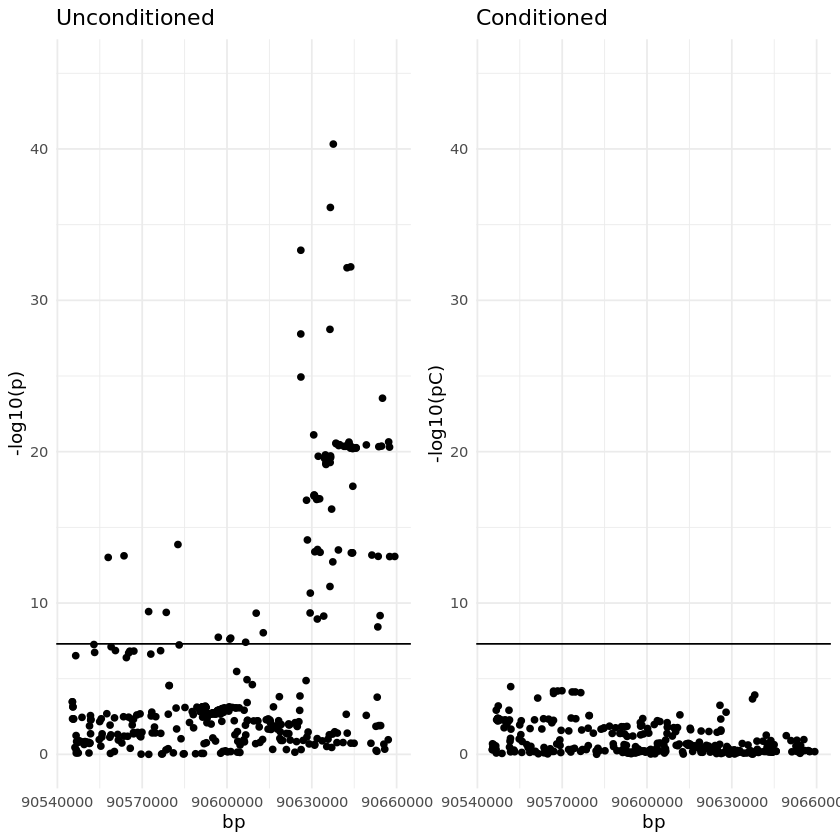

In [6]:
# plot effect of conditionining
p0=ggplot(snca_sumstats,aes(BP,-log10(`P-value`),col = ifelse(ID %in% cojo_res_joint$SNP,"cond","noncond")))+
    geom_point()+
    theme_minimal()+
    geom_hline(yintercept=-log10(5e-8))+
    scale_color_manual(values = c("red","black"))+
    ggtitle("SNCA GWAS hits - conditional signals")+
    scale_y_continuous(limits=c(0,45))+
    theme(legend.position="none")
p1=ggplot(cojo_res,aes(bp,-log10(p)))+geom_point()+theme_minimal()+geom_hline(yintercept=-log10(5e-8))+ggtitle("Unconditioned")+scale_y_continuous(limits=c(0,45))
p2=ggplot(cojo_res,aes(bp,-log10(pC)))+geom_point()+theme_minimal()+geom_hline(yintercept=-log10(5e-8))+ggtitle("Conditioned")+scale_y_continuous(limits=c(0,45))
gridExtra::grid.arrange(p1,p2,nrow=1)

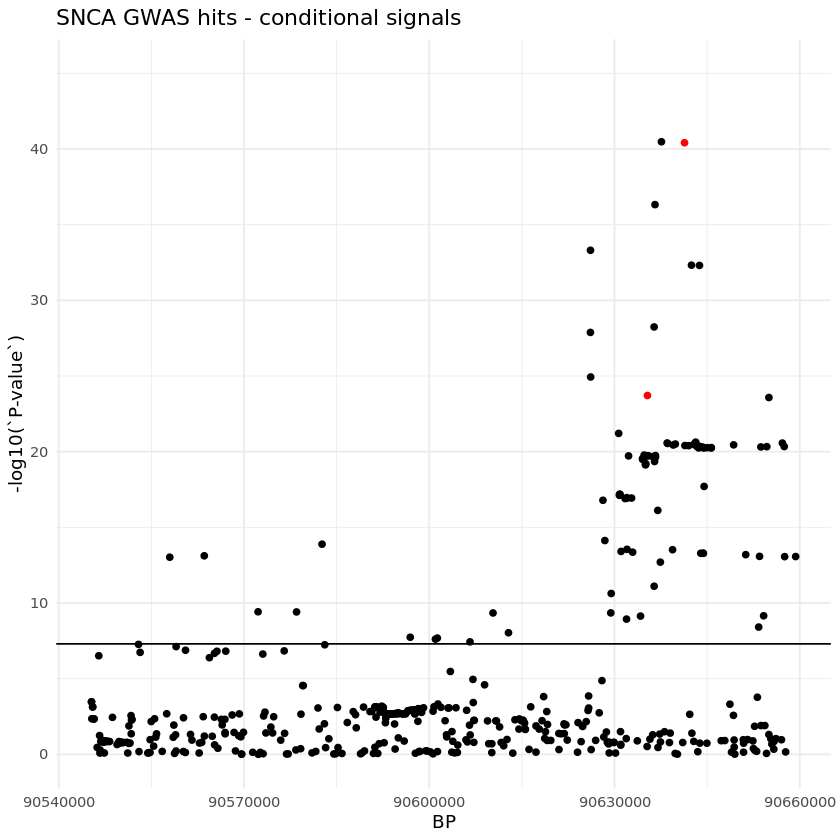

In [7]:
p0

## 4. Fine-mapping and colocalization analyses
<a id="4"></a>

In [11]:
library(coloc)
# define new ID 
snca_sumstats = snca_sumstats %>% mutate(chr_pos = paste0(CHR,":",BP))

# prepare data for coloc
snca_sumstats_coloc = list(
beta = snca_sumstats$Effect,
varbeta = snca_sumstats$StdErr^2,
snp = snca_sumstats$chr_pos,
position = snca_sumstats$BP,
type = "cc",
MAF = snca_sumstats$MinFreq,
N = 50000)

check_dataset(snca_sumstats_coloc)

NULL

In [13]:
# run finemap.abf to find approximate bayes factors
# this is single causal variant fine mapping

res = finemap.abf(snca_sumstats_coloc)

# take a look at the results
head(res)

,V.,z.,r.,lABF.,snp,position,prior,SNP.PP
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,0.00141376,3.585106,0.9658626,4.518430,4:90545298,90545298,1e-04,6.988337e-37
2,0.00141376,3.585106,0.9658626,4.518430,4:90545315,90545315,1e-04,6.988337e-37
3,0.00227529,-2.842767,0.9461792,2.362144,4:90545360,90545360,1e-04,8.089295e-38
4,0.00143641,3.385224,0.9653346,3.850237,4:90545492,90545492,1e-04,3.582460e-37
5,0.00143641,3.374670,0.9653346,3.815801,4:90545495,90545495,1e-04,3.461196e-37
6,0.00272484,-2.825670,0.9362235,2.361413,4:90545660,90545660,1e-04,8.083384e-38


,V.,z.,r.,lABF.,snp,position,prior,SNP.PP
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,0.00141376,3.585106,0.9658626,4.518430,4:90545298,90545298,1e-04,6.988337e-37
2,0.00141376,3.585106,0.9658626,4.518430,4:90545315,90545315,1e-04,6.988337e-37
3,0.00227529,-2.842767,0.9461792,2.362144,4:90545360,90545360,1e-04,8.089295e-38
4,0.00143641,3.385224,0.9653346,3.850237,4:90545492,90545492,1e-04,3.582460e-37
5,0.00143641,3.374670,0.9653346,3.815801,4:90545495,90545495,1e-04,3.461196e-37
6,0.00272484,-2.825670,0.9362235,2.361413,4:90545660,90545660,1e-04,8.083384e-38


Warning message:
“Removed 1 rows containing missing values (geom_point).”


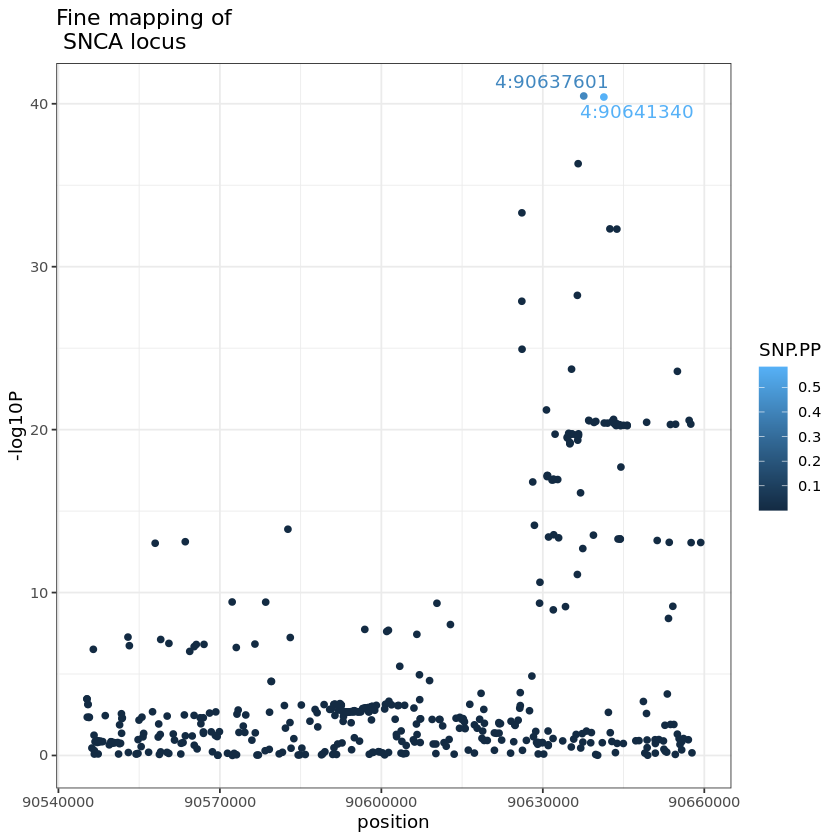

In [101]:
# plot 
library(ggrepel)

# merge results with GWAS results 
head(res)
res = res %>% 
left_join(snca_sumstats %>% select(chr_pos,`P-value`) %>% rename("snp" = chr_pos),by="snp") %>%
mutate(log10P = -log10(`P-value`))

# plot with GWAS P values and posterior probabilities (from fine mapping)
ggplot(res,aes(position,log10P,col=SNP.PP,label=snp))+
geom_point()+
geom_text_repel(data=res %>% 
                arrange(desc(SNP.PP)) %>% 
                head(n=2),mapping=aes())+
theme_bw()+
labs(y="-log10P")+
ggtitle("Fine mapping of \n SNCA locus")